<a href="https://colab.research.google.com/github/chetannitk/BeerDataScienceAssignment/blob/master/notebooks/04-k-mean-clustering-to-find-similar-beer-drinkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
    <h1> Beer Data Science Assignment <br/></h1>
    K-mean clustering to find similar group of beer drinkers.
</div>


In [1]:
## Java version should be 1.8
!java -version

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [0]:
!sudo apt install openjdk-8-jdk


In [0]:
!sudo update-alternatives --config java
## Select java 8

In [2]:
from IPython.display import HTML
import pandas as pd
import os
import numpy as np
from datetime import datetime
import wordcloud
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

#BASE_PATH = "../"
#INPUT_DATA_PATH = os.path.join(BASE_PATH, "data/raw/BeerDataScienceProject.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [3]:
## Upload BeerDataScienceProject.csv file from local system.
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data/BeerDataScienceProject.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!ls -lrt /tmp

total 405180
drwx------ 2 root root      4096 May 31 18:11 tmpqpt_vb4a
srw------- 1 root root         0 May 31 18:12 drivefs_ipc.0
srw------- 1 root root         0 May 31 18:12 drivefs_ipc.0_shell
drwxr-xr-x 3 root root      4096 May 31 19:06 tfhub_modules
drwxr-xr-x 2 root root      4096 May 31 19:44 hsperfdata_root
-rw-r--r-- 1 root root 414885425 May 31 19:44 BeerDataScienceProject.csv


In [0]:
import io
df_beer_raw = pd.read_csv('/tmp/BeerDataScienceProject.csv', encoding="ISO-8859-1")

In [6]:
df_beer_raw.shape

(528870, 13)

In [7]:
df_beer_raw.dtypes

beer_ABV              float64
beer_beerId             int64
beer_brewerId           int64
beer_name              object
beer_style             object
review_appearance     float64
review_palette        float64
review_overall        float64
review_taste          float64
review_profileName     object
review_aroma          float64
review_text            object
review_time             int64
dtype: object

### Data Cleaning
```In the below cell we can see that there are some columns where data is missing. 
   We need to remove those data points from our data set.
```

In [8]:
df_beer_raw.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [0]:
df_beer = df_beer_raw.dropna()

In [10]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508358 non-null  float64
 1   beer_beerId         508358 non-null  int64  
 2   beer_brewerId       508358 non-null  int64  
 3   beer_name           508358 non-null  object 
 4   beer_style          508358 non-null  object 
 5   review_appearance   508358 non-null  float64
 6   review_palette      508358 non-null  float64
 7   review_overall      508358 non-null  float64
 8   review_taste        508358 non-null  float64
 9   review_profileName  508358 non-null  object 
 10  review_aroma        508358 non-null  float64
 11  review_text         508358 non-null  object 
 12  review_time         508358 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 54.3+ MB


In [0]:
df_beer = df_beer.reset_index()
df_beer['id'] = df_beer.index

## Data Changes in Raw and Clean dataset

In [12]:
print("Raw data size: ", df_beer_raw.shape[0])
print("Clean data size: ", df_beer.shape[0])
print("Data points difference: ", df_beer_raw.shape[0]-df_beer.shape[0])

Raw data size:  528870
Clean data size:  508358
Data points difference:  20512


### Describe the categorical features

In [13]:
df_beer.describe(include=[np.object])

,beer_name,beer_style,review_profileName,review_text
count,508358,508358,508358,508358
unique,14028,104,22563,508007
top,Sierra Nevada Celebration Ale,American IPA,northyorksammy,#NAME?
freq,2998,42092,1732,90


### Describe the numerical features

In [14]:
df_beer.describe(include=[np.number])

,index,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time,id
count,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,5.083580e+05,508358.000000
mean,263669.490377,7.017400,21824.120840,2534.273207,3.872676,3.768993,3.840805,3.775327,3.827646,1.226175e+09,254178.500000
std,152590.091973,2.204528,22124.969107,5237.843825,0.601764,0.682355,0.706408,0.665586,0.715121,7.530843e+07,146750.458409
min,0.000000,0.010000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08,0.000000
25%,131284.250000,5.300000,1673.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.177202e+09,127089.250000
50%,263756.500000,6.500000,13850.000000,392.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.241503e+09,254178.500000
75%,395689.750000,8.500000,40418.000000,1315.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.289073e+09,381267.750000
max,528796.000000,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09,508357.000000


In [0]:
NUMERICAL_ATTRIBUTE = ['beer_ABV', 'review_appearance', 'review_palette', 
                       'review_overall', 'review_taste', 'review_aroma', 'review_time']
CATEGORICAL_ATTRIBUTE = ['beer_name', 'beer_style', 'review_profileName', 'review_text']

In [16]:
df_beer.sample(4)

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,id
73465,76019,6.7,42533,140,Sierra Nevada Southern Hemisphere Harvest Fres...,American IPA,4.0,4.0,3.0,3.5,hopstorm,4.0,"First of all, mad props to SN for all its incr...",1243120735,73465
15846,17177,12.0,17538,1199,Founders Devil Dancer,American Double / Imperial IPA,4.0,4.5,4.0,4.0,Beerandraiderfan,4.0,"Big thick orange and amber brown pour, it look...",1290227655,15846
20039,21378,8.3,11757,1199,Founders Breakfast Stout,American Double / Imperial Stout,4.5,4.5,4.5,4.5,tippebrewcrew2,4.0,I love you founders. Pours a silky black with ...,1269322436,20039
155649,160829,9.6,43687,3818,Creme Brulee (Imperial Milk Stout),American Double / Imperial Stout,4.5,5.0,4.5,4.5,TheHoppiest,4.5,Poured from a 22 oz bottle into an oversized s...,1292899190,155649


<div class="alert alert-info">
Convert the review timestamp to datetime format
</div>

In [0]:
df_beer['d_review_time'] = df_beer.review_time.apply(lambda t: datetime.fromtimestamp(t))

In [0]:
df_beer['d_review_time_year'] = df_beer['d_review_time'].dt.year
df_beer['d_review_time_month'] = df_beer['d_review_time'].dt.month

<div class="alert alert-success">
Q7) How do find similar beer drinkers by using written reviews only?   
</div>

In [19]:
!pip install tensorflow_text

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
tf.executing_eagerly()

True

In [0]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [22]:
!pip install pyspark

In [26]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import pyspark
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *


%matplotlib inline

print (pyspark.__version__)

2.4.5


In [0]:
sc = SparkContext("local[*]", "First App1")
spark = SparkSession(sc)

In [0]:
train = df_beer.review_text.tolist()
list_train = [train[i:i+100] for i in range(0,len(train),100)]

In [30]:
from tqdm import tqdm
data = []
for d in tqdm(list_train):
    data.extend(embed(d).numpy())

100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


In [0]:
df = pd.DataFrame(data, columns=["c"+str(i) for i in range(512)])
df['id'] = df.index
df = spark.createDataFrame(df) 


In [32]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------

In [33]:
FEATURES_COL = ["c"+str(i) for i in range(512)]
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-------------+-------------+-----------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+------------+------------+------------+-----------+------------+-------------+-------------+------------+-------------+-------------+------------+------------+------------+------------+-------------+-----------+-------------+-------------+------------+-------------+-----------+------------+-------------+-------------+------------+------------+-------------+-------------+------------+-------------+-------------+------------+-----------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+------------+-------------+------------+------------+------------+-------------+-------------+------------+-------------+------------+------------+-----------+-----

In [34]:
df = df.na.drop()
df.show()

+-------------+-------------+-----------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+------------+------------+------------+-----------+------------+-------------+-------------+------------+-------------+-------------+------------+------------+------------+------------+-------------+-----------+-------------+-------------+------------+-------------+-----------+------------+-------------+-------------+------------+------------+-------------+-------------+------------+-------------+-------------+------------+-----------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+------------+-------------+------------+------------+------------+-------------+-------------+------------+-------------+------------+------------+-----------+-----

In [35]:
##Create a features column to be used in the clustering
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.03805545717477...|
|  1|[-0.0284477174282...|
|  2|[0.00820898823440...|
|  3|[0.01986976712942...|
|  4|[0.02205277606844...|
|  5|[0.04833811149001...|
|  6|[0.04575408995151...|
|  7|[0.00198698253370...|
|  8|[0.05345362797379...|
|  9|[-0.0021790701430...|
| 10|[0.04845911264419...|
| 11|[0.00456383731216...|
| 12|[0.00574429379776...|
| 13|[0.03521178662776...|
| 14|[0.02326397411525...|
| 15|[-0.0320433340966...|
| 16|[0.01842947304248...|
| 17|[-0.0140794469043...|
| 18|[-0.0111503880470...|
| 19|[-0.0592926926910...|
+---+--------------------+
only showing top 20 rows



In [37]:
from tqdm import tqdm

cost = np.zeros(20)
for k in tqdm(range(2,20)):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) 

100%|██████████| 18/18 [06:19<00:00, 21.09s/it]


Text(0, 0.5, 'cost')

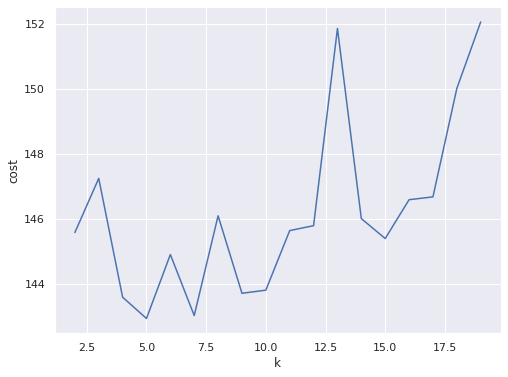

In [38]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')